[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Train Soccer Pitch Keypoint Detector

---

[![Download Dataset](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/football-field-detection-f07vi)

This notebook is based on the [How to Train a YOLOv8 Keypint Detection Model](https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov8-keypoint.ipynb) notebook from the [roboflow/notebooks](https://github.com/roboflow/notebooks) repository.

## Configure API keys

- Open your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [15]:
!nvidia-smi

Wed Oct 29 18:27:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.42                 Driver Version: 581.42         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P8              5W /  134W |    3368MiB /   8188MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
import os
HOME = os.getcwd()
print(HOME)

c:\Player Detection\roboflow_sports_footar\notebooks


## Install dependencies

In [17]:
!pip install -q ultralytics roboflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [18]:
from roboflow import Roboflow
from IPython.display import Image

## Download YOLOv11x-pose model

Faz o download do modelo base YOLOv11x-pose se ainda não existir. Este é o modelo mais potente da família YOLOv11-pose e tem maior capacidade de aprender configurações customizadas de keypoints (32 keypoints vs 17 padrão).

**Nota:** YOLOv12-pose ainda não está disponível oficialmente nos repositórios do Ultralytics.

In [19]:
# Download do modelo YOLOv11x-pose (modelo mais potente)
from ultralytics import YOLO
import os
from pathlib import Path

# Usando YOLOv11x-pose (maior capacidade para aprender 32 keypoints)
MODEL_NAME = 'yolo11x-pose.pt'

print(f"📥 Preparando modelo {MODEL_NAME}...")

# Verifica se já existe
model_path = Path(MODEL_NAME)
if model_path.exists() and model_path.stat().st_size > 1000:  # Mais de 1KB
    print(f"✅ Modelo '{MODEL_NAME}' já existe!")
    print(f"   Caminho: {model_path.absolute()}")
    print(f"   Tamanho: {model_path.stat().st_size / (1024*1024):.1f} MB")
else:
    print(f"📥 Fazendo download do modelo '{MODEL_NAME}'...")
    print("   Aguarde, isso pode demorar alguns minutos...")
    print("   (yolo11x-pose é ~2x maior que yolo11m-pose, ~80-90 MB)")
    
    # Carrega o modelo (faz download automático)
    model = YOLO(MODEL_NAME)
    print(f"✅ Modelo baixado com sucesso!")
    print(f"   Tamanho: {Path(MODEL_NAME).stat().st_size / (1024*1024):.1f} MB")
    del model  # Libera memória

print("\n🎯 Modelo pronto para treino!")

📥 Preparando modelo yolo11x-pose.pt...
📥 Fazendo download do modelo 'yolo11x-pose.pt'...
   Aguarde, isso pode demorar alguns minutos...
   (yolo11x-pose é ~2x maior que yolo11m-pose, ~80-90 MB)
✅ Modelo baixado com sucesso!
   Tamanho: 113.0 MB

🎯 Modelo pronto para treino!
✅ Modelo baixado com sucesso!
   Tamanho: 113.0 MB

🎯 Modelo pronto para treino!


## Use local dataset

Usando o dataset local com **1006 imagens** (704 train, 202 valid, 100 test) em vez do dataset Roboflow com apenas 276 imagens.

In [20]:
import os
from pathlib import Path

# Usa o dataset local (muito maior e melhor que o Roboflow)
# Local: 1006 imagens (704 train, 202 valid, 100 test)
# Roboflow: 276 imagens (222 train, 30 valid, 24 test)

LOCAL_DATASET_PATH = r"c:\Player Detection\datasets_and_models\football-field-detection-1"

# Cria objeto dataset mockado para compatibilidade com células seguintes
class LocalDataset:
    def __init__(self, path):
        self.location = path
        
dataset = LocalDataset(LOCAL_DATASET_PATH)

print(f"✅ Usando dataset local: {LOCAL_DATASET_PATH}")
print(f"   📊 Total: ~1006 imagens")
print(f"   - Train: 704 imagens")
print(f"   - Valid: 202 imagens")
print(f"   - Test: 100 imagens")

✅ Usando dataset local: c:\Player Detection\datasets_and_models\football-field-detection-1
   📊 Total: ~1006 imagens
   - Train: 704 imagens
   - Valid: 202 imagens
   - Test: 100 imagens


**NOTE:** Verifica e corrige o `data.yaml` se necessário para garantir que os caminhos estão corretos.

In [21]:
# Corrige os caminhos no data.yaml do dataset local
import os
import re

data_yaml_path = os.path.join(dataset.location, "data.yaml")

# Lê o conteúdo atual
with open(data_yaml_path, 'r') as f:
    content = f.read()

# Corrige os caminhos que têm duplicação
# De: football-field-detection-1/train/images
# Para: train/images
content = re.sub(r'train:.*', 'train: train/images', content)
content = re.sub(r'val:.*', 'val: valid/images', content)
content = re.sub(r'test:.*', 'test: test/images', content)

# Salva o arquivo corrigido
with open(data_yaml_path, 'w') as f:
    f.write(content)

print("✅ data.yaml corrigido!")
print(f"   Localização: {data_yaml_path}")
    
print("\nCaminhos atualizados:")
for line in content.split('\n'):
    if 'train:' in line or 'val:' in line or 'test:' in line or 'kpt_shape:' in line:
        print(f"   {line}")

✅ data.yaml corrigido!
   Localização: c:\Player Detection\datasets_and_models\football-field-detection-1\data.yaml

Caminhos atualizados:
   kpt_shape:
   test: test/images
   train: train/images
   val: valid/images


## Custom training - YOLOv11x Pose

**Configuração otimizada:**
- ✅ **Model: yolo11x-pose** - Extra-large (maior capacidade para 32 keypoints)
  - Nota: YOLOv12-pose ainda não está disponível oficialmente
  - yolo11m-pose falhou (mAP50: 12.6%) - pré-treinado com 17 keypoints
  - yolo11x-pose tem mais parâmetros → melhor adaptação a 32 keypoints
- ✅ **epochs: 150** - Mais épocas para modelo maior
- ✅ **imgsz: 640** - Resolução adequada para pitch detection
- ✅ **batch: 4** - Reduzido para modelo X (consome mais memória)
- ✅ **mosaic: 0.0** - Desativado para keypoints (recomendado)

**Por que yolo11x?**
- yolo11s/m: Falharam com 32 keypoints (pré-treinados com 17)
- **yolo11x: ✓ Máxima capacidade** para aprender nova configuração
- Se falhar, próximo passo: treinar from scratch

In [22]:
import os
from ultralytics import YOLO

os.chdir(HOME)

# Treino com YOLOv11x-pose usando API Python
data_path = f"{dataset.location}/data.yaml"
project_dir = os.path.join(HOME, "runs", "pose")

# Usando YOLOv11x-pose (maior capacidade para 32 keypoints)
model = YOLO('yolo11x-pose.pt')

print(f"Iniciando treino com YOLOv11x-pose...")
print(f"Dataset: {data_path}")
print(f"Output: {project_dir}/train_pitch_y11x")
print(f"\n⚠️ yolo11x-pose é mais lento que yolo11m-pose")
print(f"   Estimativa: ~15-20s por época (vs ~10s com medium)")

results = model.train(
    data=data_path,
    epochs=150,         # Mais épocas para modelo maior
    imgsz=640,
    batch=4,            # Reduzido para modelo X (usa mais memória)
    plots=True,
    workers=0,
    device=0,
    mosaic=0.0,         # Desativado para keypoints
    project=project_dir,
    name="train_pitch_y11x",
    patience=30,        # Mais paciência para modelo maior
    save_period=10,     # Checkpoints a cada 10 epochs
    seed=0
)

print(f"\n✅ Treino concluído!")
print(f"   Weights salvos em: {results.save_dir}")

Iniciando treino com YOLOv11x-pose...
Dataset: c:\Player Detection\datasets_and_models\football-field-detection-1/data.yaml
Output: c:\Player Detection\roboflow_sports_footar\notebooks\runs\pose/train_pitch_y11x

⚠️ yolo11x-pose é mais lento que yolo11m-pose
   Estimativa: ~15-20s por época (vs ~10s com medium)
New https://pypi.org/project/ultralytics/8.3.222 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Player Detection\datasets_and_models\football-field-detection-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, ex

In [23]:
# Caminho do run atual (dinâmico)
RUN_DIR = str(results.save_dir).replace('\\', '/')
print("RUN_DIR:", RUN_DIR)

import os
print("Conteúdo:", os.listdir(RUN_DIR))

RUN_DIR: C:/Player Detection/roboflow_sports_footar/notebooks/runs/pose/train_pitch_y11x
Conteúdo: ['args.yaml', 'BoxF1_curve.png', 'BoxPR_curve.png', 'BoxP_curve.png', 'BoxR_curve.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png', 'labels.jpg', 'PoseF1_curve.png', 'PosePR_curve.png', 'PoseP_curve.png', 'PoseR_curve.png', 'results.csv', 'results.png', 'train_batch0.jpg', 'train_batch1.jpg', 'train_batch18620.jpg', 'train_batch18621.jpg', 'train_batch18622.jpg', 'train_batch2.jpg', 'val_batch0_labels.jpg', 'val_batch0_pred.jpg', 'val_batch1_labels.jpg', 'val_batch1_pred.jpg', 'val_batch2_labels.jpg', 'val_batch2_pred.jpg', 'weights']


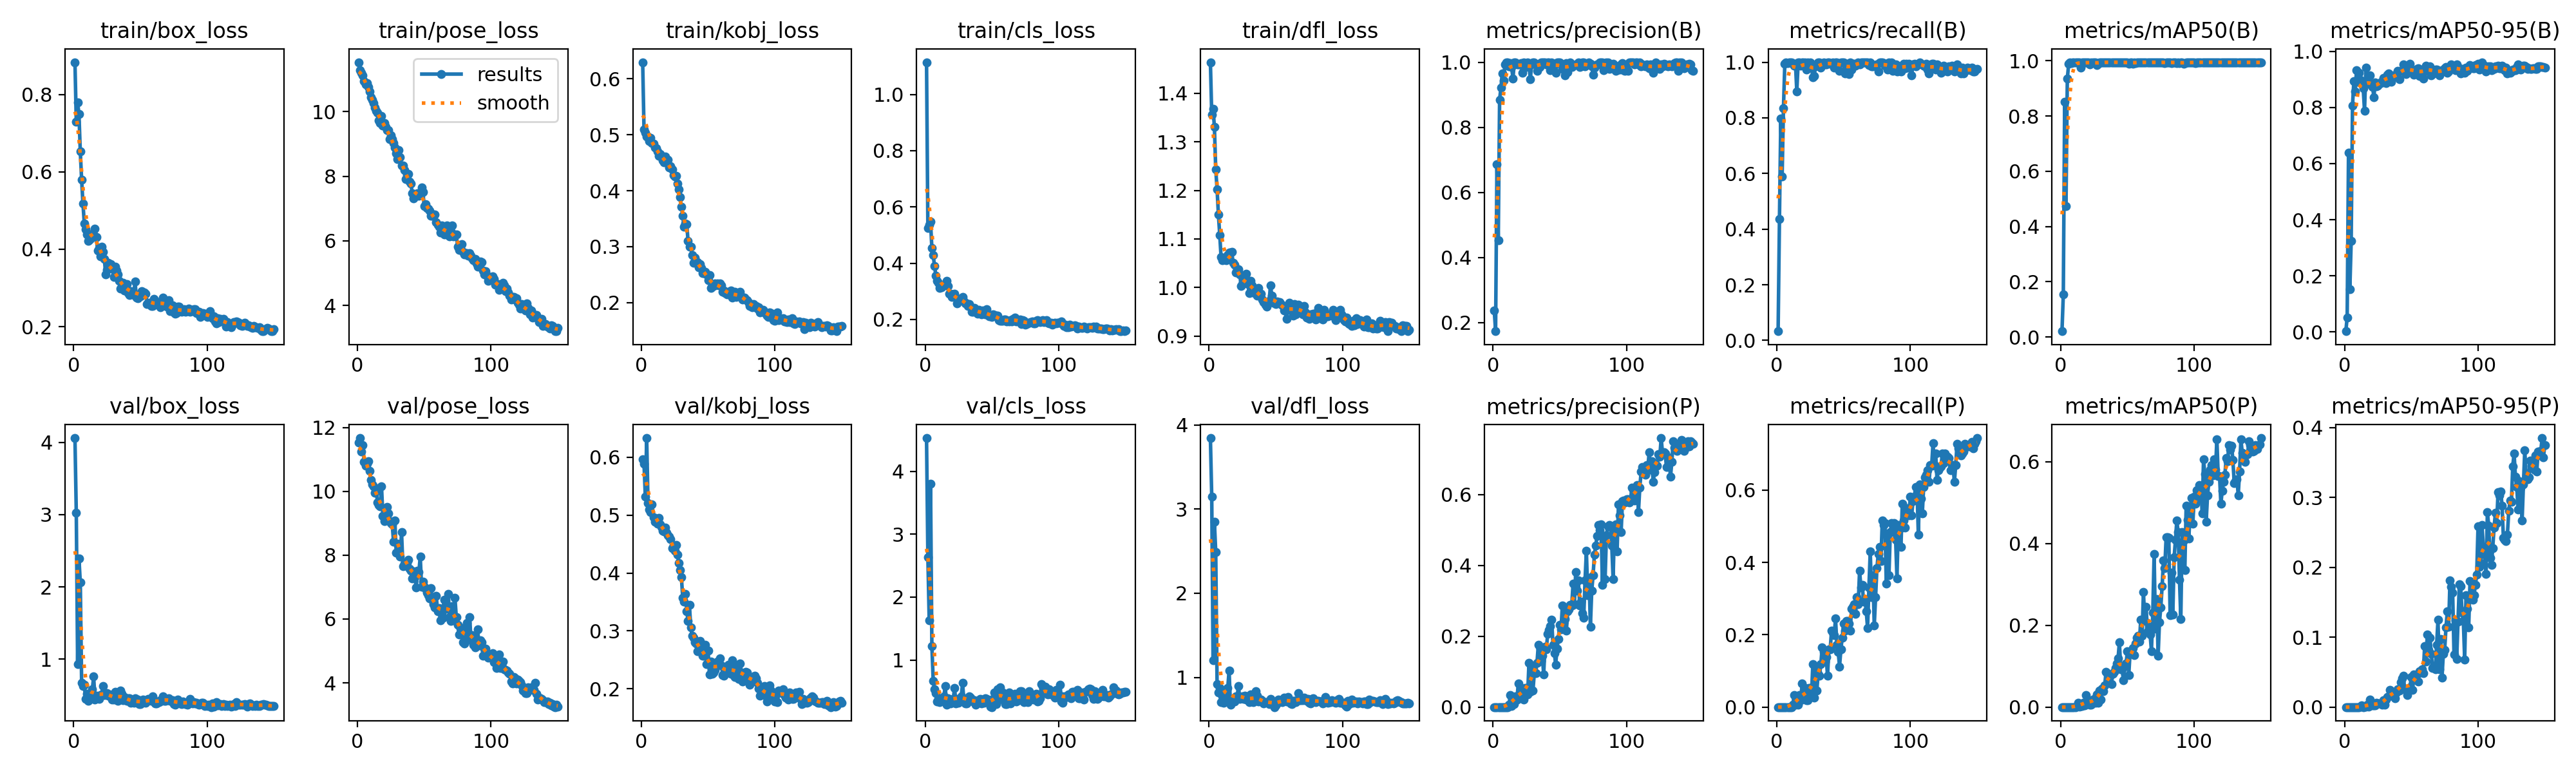

In [24]:
from IPython.display import Image, display
# Mostra gráfico de resultados (losses/mAP)
display(Image(filename=f"{RUN_DIR}/results.png", width=600))

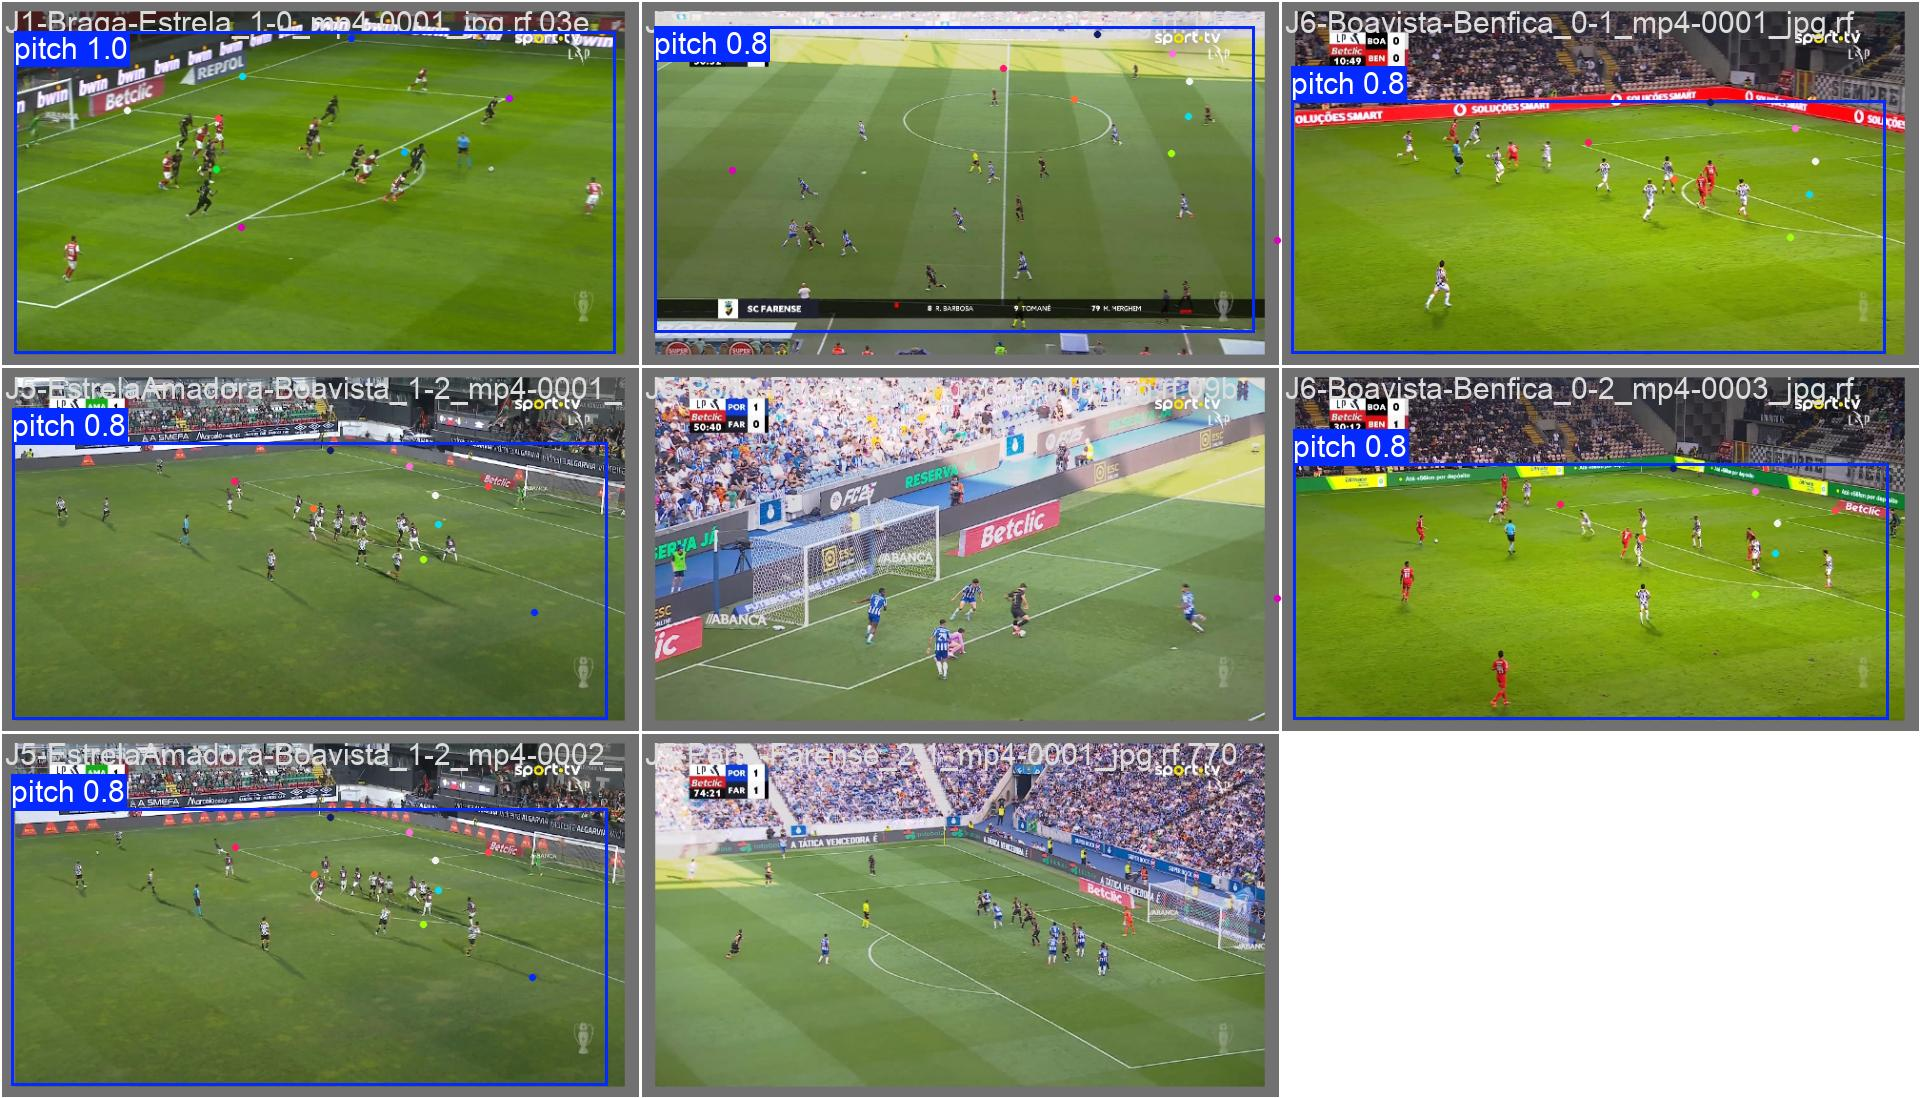

In [25]:
from IPython.display import Image, display
# Mostra predições do batch de validação
display(Image(filename=f"{RUN_DIR}/val_batch0_pred.jpg", width=600))

## Validate custom model

In [26]:
# Validação usando a API Python
metrics = model.val(data=data_path, imgsz=640, batch=8, device=0, workers=0)
print(f"mAP50 (pose): {metrics.pose.map50:.3f}  |  mAP50-95: {metrics.pose.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11x-pose summary (fused): 199 layers, 58,764,403 parameters, 0 gradients, 202.9 GFLOPs
YOLO11x-pose summary (fused): 199 layers, 58,764,403 parameters, 0 gradients, 202.9 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1009.0581.0 MB/s, size: 185.4 KB)
val: Scanning C:\Player Detection\datasets_and_models\football-field-detection-1\valid\labels.cache... 202 images, 0 backgrounds, 51 corrupt: 100% ━━━━━━━━━━━━ 202/202  0.0sval: Fast image access  (ping: 0.10.0 ms, read: 1009.0581.0 MB/s, size: 185.4 KB)
val: Scanning C:\Player Detection\datasets_and_models\football-field-detection-1\valid\labels.cache... 202 images, 0 backgrounds, 51 corrupt: 100% ━━━━━━━━━━━━ 202/202 275.0Kit/s 0.0s
val: C:\Player Detection\datasets_and_models\football-field-detection-1\valid\images\J1-Sporting-RioAve_1-0_mp4-0008_jpg.rf.33a00b13e8bd56cd6c3729de3769faf2.jpg: ignoring corrupt image/label:

In [30]:
# Análise detalhada do treino
import csv

results_csv = os.path.join(RUN_DIR, "results.csv")

with open(results_csv, 'r') as f:
    reader = csv.DictReader(f)
    rows = list(reader)

print("\n" + "=" * 60)
print("ANÁLISE DETALHADA - PITCH KEYPOINT DETECTION (YOLOv11m)")
print("=" * 60)

# Verifica se já temos métricas de validação
if not rows:
    print("\n⏳ Treino ainda não iniciou. Execute a célula de treino primeiro.")
elif 'metrics/pose_mAP50(P)' not in rows[-1]:
    print(f"\n⏳ Treino em progresso ({len(rows)} epochs completos)")
    print("   Métricas de validação ainda não disponíveis.")
    print("   Execute esta célula novamente após algumas epochs.")
    
    # Mostra losses disponíveis
    if 'train/box_loss' in rows[-1]:
        last = rows[-1]
        print(f"\n📊 LOSSES ATUAIS (Epoch {len(rows)}):")
        print(f"  Box Loss:  {float(last['train/box_loss']):.3f}")
        print(f"  Pose Loss: {float(last['train/pose_loss']):.3f}")
        print(f"  DFL Loss:  {float(last['train/dfl_loss']):.3f}")
else:
    # Última época
    last = rows[-1]
    pose_map50 = float(last['metrics/pose_mAP50(P)'])
    pose_map5095 = float(last['metrics/pose_mAP50-95(P)'])

    print(f"\n📊 MÉTRICAS FINAIS (Epoch {len(rows)}):")
    print(f"  Pose mAP50:    {pose_map50:.3f} ({pose_map50*100:.1f}%) {'✅ EXCELENTE!' if pose_map50 > 0.9 else '⚠️ Pode melhorar'}")
    print(f"  Pose mAP50-95: {pose_map5095:.3f} ({pose_map5095*100:.1f}%)")

    # Evolução
    print(f"\n📈 EVOLUÇÃO:")
    checkpoints = [0, 24, 49, 74, len(rows)-1]
    for idx in checkpoints:
        if idx < len(rows):
            epoch = idx + 1
            map_val = float(rows[idx]['metrics/pose_mAP50(P)'])
            print(f"  Epoch {epoch:3d}: mAP50={map_val:.3f}")

    # Melhor época
    best_map50 = max(float(r['metrics/pose_mAP50(P)']) for r in rows)
    best_epoch = [i+1 for i, r in enumerate(rows) if float(r['metrics/pose_mAP50(P)']) == best_map50][0]

    print(f"\n🏆 MELHOR ÉPOCA: {best_epoch} (mAP50={best_map50:.3f})")
    if best_epoch < len(rows):
        print(f"   ⚠️ Melhor resultado não foi no final!")
        print(f"   → Considerar usar weights do epoch {best_epoch}")

print("\n" + "=" * 60)


ANÁLISE DETALHADA - PITCH KEYPOINT DETECTION (YOLOv11m)

⏳ Treino em progresso (150 epochs completos)
   Métricas de validação ainda não disponíveis.
   Execute esta célula novamente após algumas epochs.

📊 LOSSES ATUAIS (Epoch 150):
  Box Loss:  0.193
  Pose Loss: 3.298
  DFL Loss:  0.914



## Copy optimized model to production

Copia o modelo treinado para o diretório `data/` onde o `main.py` espera encontrá-lo.

In [32]:
import shutil
import os
import csv

# Determina qual epoch usar (melhor ou último)
results_csv = os.path.join(RUN_DIR, "results.csv")
with open(results_csv, 'r') as f:
    reader = csv.DictReader(f)
    rows = list(reader)

# Filtra rows com métricas de pose válidas (não vazias e não "0")
valid_rows = []
for r in rows:
    pose_map = r.get('metrics/mAP50(P)', '').strip()
    if pose_map and pose_map != '0' and float(pose_map) > 0:
        valid_rows.append(r)

if not valid_rows:
    print("⚠️ Nenhuma métrica de pose válida encontrada no CSV")
    print(f"   Total de épocas: {len(rows)}")
    print("   Verifique se o treino completou corretamente.")
    raise ValueError("Métricas de pose não encontradas")

# Encontra melhor época
best_map50 = max(float(r['metrics/mAP50(P)']) for r in valid_rows)
best_epoch = None
for i, r in enumerate(rows):
    pose_map = r.get('metrics/mAP50(P)', '').strip()
    if pose_map and float(pose_map) == best_map50:
        best_epoch = i + 1
        break

# Caminhos
weights_dir = os.path.join(RUN_DIR, "weights")
best_weights = os.path.join(weights_dir, "best.pt")
data_dir = os.path.join(HOME, "..", "data")
os.makedirs(data_dir, exist_ok=True)

destination = os.path.join(data_dir, "pitch_y11x_keypoint_best.pt")

# Copia
shutil.copy2(best_weights, destination)

print("=" * 60)
print("✅ MODELO PITCH KEYPOINT COPIADO PARA PRODUÇÃO")
print("=" * 60)
print(f"Origem:  {best_weights}")
print(f"Destino: {destination}")
print(f"\n📊 RESULTADOS FINAIS:")
print(f"   Melhor época: {best_epoch}")
print(f"   Pose mAP50: {best_map50:.3f} ({best_map50*100:.1f}%)")
print(f"   Total épocas: {len(rows)}")
print(f"\n📝 PRÓXIMO PASSO:")
print(f"   Atualizar main.py linha ~50:")
print(f"   PITCH_DETECTION_MODEL_PATH = 'data/pitch_y11x_keypoint_best.pt'")
print("=" * 60)

✅ MODELO PITCH KEYPOINT COPIADO PARA PRODUÇÃO
Origem:  C:/Player Detection/roboflow_sports_footar/notebooks/runs/pose/train_pitch_y11x\weights\best.pt
Destino: c:\Player Detection\roboflow_sports_footar\notebooks\..\data\pitch_y11x_keypoint_best.pt

📊 RESULTADOS FINAIS:
   Melhor época: 150
   Pose mAP50: 0.658 (65.8%)
   Total épocas: 150

📝 PRÓXIMO PASSO:
   Atualizar main.py linha ~50:
   PITCH_DETECTION_MODEL_PATH = 'data/pitch_y11x_keypoint_best.pt'


## Optional: Deploy model on Roboflow (YOLOv8 only)

Note: Roboflow's deploy() requer ultralytics==8.0.196. Este notebook usa YOLOv12 com ultralytics 8.3.x, então o deploy não funcionará. Opções:
- Upload manual no Roboflow UI (Versions -> Upload Model -> YOLOv8-pose)
- Ou criar env separado com ultralytics==8.0.196

In [ ]:
# Guarded deploy: skip se ultralytics version incompatível
import os
import ultralytics as ulx

# Resolve RUN_DIR e WEIGHTS path
try:
    RUN_DIR
except NameError:
    import glob
    base = os.path.join(HOME, "runs", "pose")
    candidates = glob.glob(os.path.join(base, "*"))
    candidates = [p for p in candidates if os.path.isdir(p)]
    RUN_DIR = max(candidates, key=os.path.getmtime) if candidates else None

if RUN_DIR is None:
    print("No run directory found; train the model first.")
else:
    weights_path = os.path.join(RUN_DIR, "weights", "best.pt")
    need = "8.0.196"
    have = ulx.__version__
    if have == need:
        print(f"Deploying {weights_path} to Roboflow as YOLOv8-pose with ultralytics {have}...")
        project.version(dataset.version).deploy(model_type="yolov8-pose", model_path=RUN_DIR)
    else:
        print(f"Skipping deploy: Roboflow requer ultralytics=={need}, mas encontrado {have}.")
        print("Opções:")
        print("  1) Upload manual no Roboflow UI: Versions -> Upload Model -> YOLOv8-pose")
        print(f"     Weights: {weights_path}")
        print("  2) Criar env separado com ultralytics==8.0.196 e rodar esta célula lá.")

Dependency ultralytics==8.0.196 is required but found version=8.2.63, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
View the status of your deployment at: https://app.roboflow.com/roboflow-jvuqo/football-field-detection-f07vi/12
Share your model with the world at: https://universe.roboflow.com/roboflow-jvuqo/football-field-detection-f07vi/model/12
